# ME480 project 01 - Bacterial mechanotaxis: tracking group behaviors

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import pims
from tqdm import tqdm
import pandas as pd
import trackpy as tp
from IPython.display import Video   
from tifffile import tifffile as tiff

### Usefull functions

In [2]:
def plot_2_by_2(img1, img2, title1, title2, size, fig_title=None, annotation=False, dilute=True):
    # plot the image and the zoomed image side by side
    fig, ax = plt.subplots(1, 2, figsize=size)
    # add a figure title
    if fig_title:
        fig.suptitle(fig_title, fontsize=16)
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title(title1)
    if annotation:
        if dilute:
            ax[0].set_xlabel('333 $\mu m$')
            ax[0].set_ylabel('333 $\mu m$')
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[0].plot([1600, 1662], [1850, 1850], color='blue', linewidth=3) # 1 pixel = 0.1625 microns --> 10 microns = 61.25 pixels
            ax[0].text(1500, 2000, '10 $\mu m$', color='blue', fontsize=16)
        else:
            ax[0].set_xlabel('374 $\mu m$')
            ax[0].set_ylabel('374 $\mu m$')
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[0].plot([1600, 1662], [1850, 1850], color='blue', linewidth=3) # 1 pixel = 0.1625 microns --> 10 microns = 61.25 pixels
            ax[0].text(1500, 2000, '10 $\mu m$', color='blue', fontsize=16)

    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title(title2)
    if annotation:
        ax[1].set_xlabel('81.25 $\mu m$') # 1 pixel = 0.1625 microns --> 500 pixels = 81.25 microns
        ax[1].set_ylabel('81.25 $\mu m$') # 1 pixel = 0.1625 microns --> 500 pixels = 81.25 microns
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].plot([400, 462], [450, 450], color='white', linewidth=3) # 1 pixel = 0.1625 microns --> 10 microns = 61.25 pixels
        ax[1].text(380, 490, '10 $\mu m$', color='white', fontsize=16)

    plt.show()

In [3]:
# play the video (press q to quit at any time)
def play_video(vid):
    for idx in range(vid.shape[0]):
        cv2.imshow('video', np.array(vid[idx,...], dtype=np.uint8))
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

### Usefull constants

In [5]:
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
          (255, 255, 0), (255, 0, 255), (0, 255, 255),
          (128, 0, 0), (0, 128, 0), (0, 0, 128),
          (128, 128, 0), (128, 0, 128), (0, 128, 128),
          (64, 0, 0), (0, 64, 0), (0, 0, 64),
          (64, 64, 0), (64, 0, 64), (0, 64, 64),
          (192, 0, 0), (0, 192, 0), (0, 0, 192),
          (192, 192, 0), (192, 0, 192), (0, 192, 192)]

## Data loading

In [6]:
# load the .tif video file
v_pilG_dilute = pims.TiffStack('../data_project1/pilG_dilute_PC.tif')
v_pilG_dense = pims.TiffStack('../data_project1/pilG_dense_PC.tif')
v_pilH_dilute = pims.TiffStack('../data_project1/pilH_dilute_PC.tif')
v_pilH_dense = pims.TiffStack('../data_project1/pilH_dense_PC.tif')
v_WT_dense = pims.TiffStack('../data_project1/WT_dense_PC.tif')
v_WT_dilute = pims.TiffStack('../data_project1/WT_dilute_PC.tif')

v_pilH_dense_control = pims.TiffStack('../data_project1/pilH_dense_mSc.tif')

# convert the tiff to an np array and put them into a dictionnary
data = {}
data['pilG_dilute'] = np.array(v_pilG_dilute)
data['pilG_dense'] = np.array(v_pilG_dense)
data['pilH_dilute'] = np.array(v_pilH_dilute)
data['pilH_dense'] = np.array(v_pilH_dense)
data['WT_dense'] = np.array(v_WT_dense)
data['WT_dilute'] = np.array(v_WT_dilute)

data['pilH_dense_control'] = np.array(v_pilH_dense_control)

## Segmentation

0: black
255: white

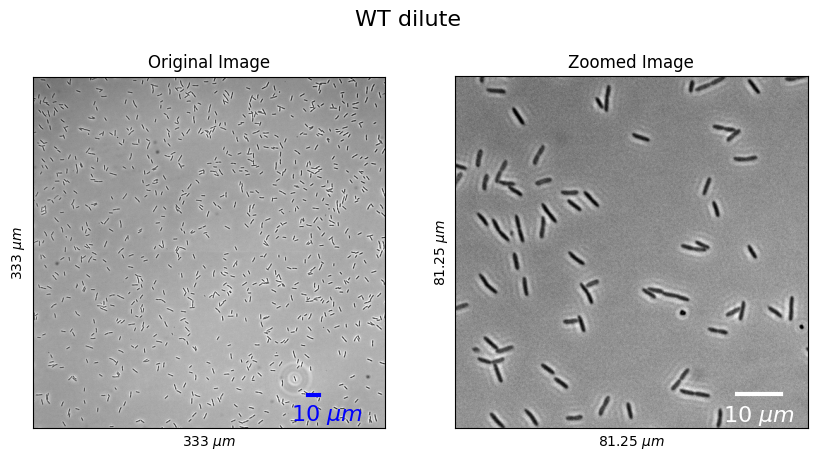

In [7]:
image = data['WT_dilute'][0,:,:]
zoom_img = image[0:500, 0:500]

# plot the image and the zoomed image side by side
plot_2_by_2(image, zoom_img, 'Original Image', 'Zoomed Image', (10, 5), fig_title='WT dilute', annotation=True)


(2044, 2048)


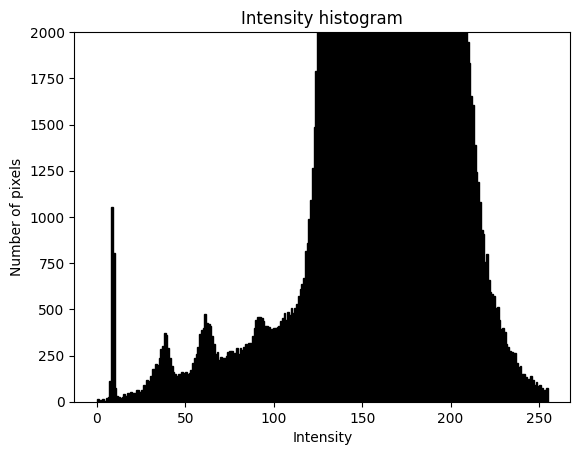

In [8]:
video = data['WT_dilute']
# for each pixel in the video, compute the mean intensity
mean_intensity = np.mean(video, axis=0)
print(mean_intensity.shape)

# plot the intensity histogram of the image
plt.hist(mean_intensity.ravel(), bins=256, range=(0.0, 255.0), fc='k', ec='k')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.title('Intensity histogram')
plt.ylim(0, 2000)
plt.show()

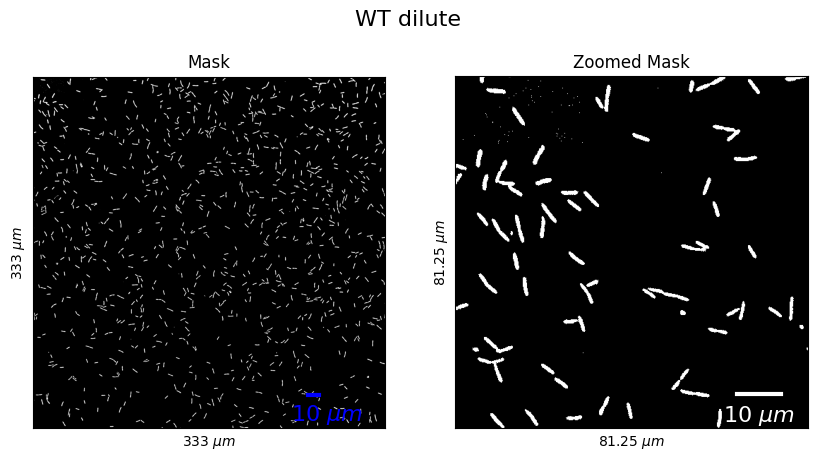

In [9]:
# create a intensity threshold mask for the first frame of the video
mask = image < 100 # 80 for dense
zoom_mask = mask[0:500, 0:500]

# plot the mask and the zoomed mask side by side
plot_2_by_2(mask, zoom_mask, 'Mask', 'Zoomed Mask', (10, 5), fig_title='WT dilute', annotation=True)

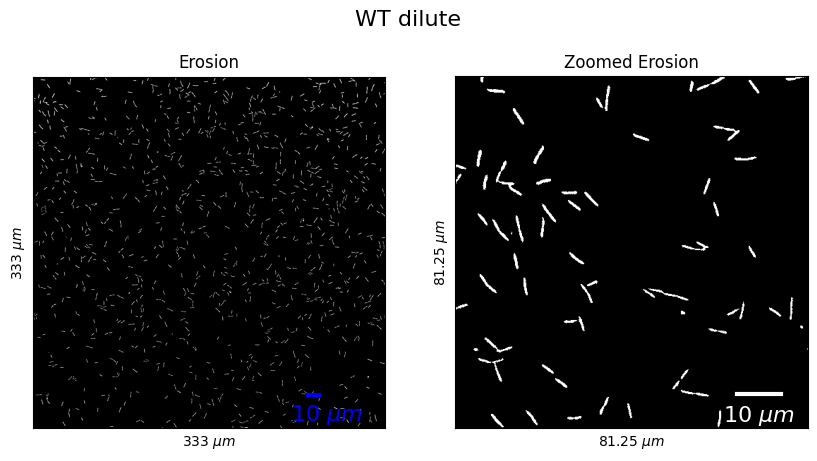

In [10]:
# apply an cross erosion to the mask
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
erosion = cv2.erode(mask.astype(np.uint8),kernel,iterations = 1)
zoom_erosion = erosion[0:500, 0:500]

# plot the erosion and the zoomed erosion side by side
plot_2_by_2(erosion, zoom_erosion, 'Erosion', 'Zoomed Erosion', (10, 5), fig_title='WT dilute', annotation=True)

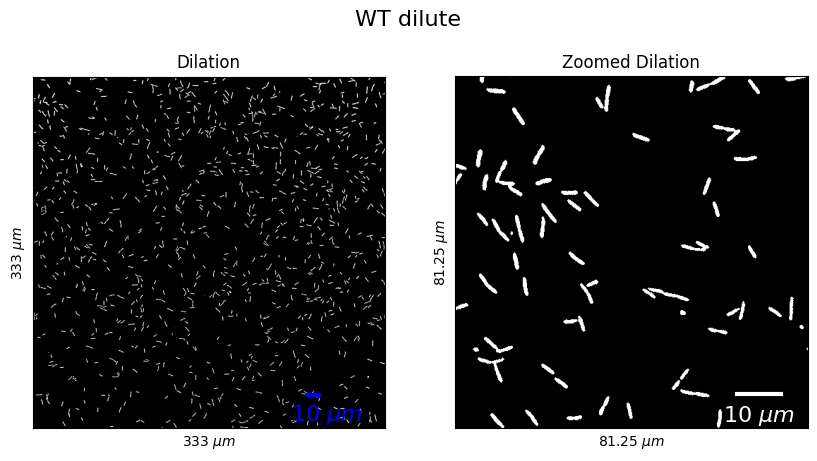

In [11]:
# apply a cross dilation to the erosion
dilation = cv2.dilate(erosion,kernel,iterations = 1)
zoom_dilation = dilation[0:500, 0:500]

# plot the dilation and the zoomed dilation side by side
plot_2_by_2(dilation, zoom_dilation, 'Dilation', 'Zoomed Dilation', (10, 5), fig_title='WT dilute', annotation=True)

In [12]:
# play the video (press q to quit at any time)
play_video(data['WT_dilute'])

In [13]:
# function to segment an entire video
def segment(video, threshold=100):
    # apply threshold to the video
    video_threshold = video < threshold

    # apply erosion to the video
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    video_erosion = video_threshold.copy()
    print('Applying erosion to the video...')
    for i in tqdm(range(video_threshold.shape[0])):
        video_erosion[i,...] = cv2.erode(video_threshold[i,...].astype(np.uint8),kernel,iterations = 1)

    # apply dilation to the video
    video_dilation = video_erosion.copy()
    print('Applying dilation to the video...')
    for i in tqdm(range(video_erosion.shape[0])):
        video_dilation[i,...] = cv2.dilate(video_erosion[i,...].astype(np.uint8),kernel,iterations = 1)
    
    return video_dilation

In [24]:
# iterate over the videos and segment them, then save them as a .tif file
for key, value in data.items():
    print('Segmenting {}...'.format(key))
    temp = segment(value, threshold=100)

    # save the segmented video
    print('Saving {}...'.format(key))
    tiff.imwrite('../data_project1/{}_segmented.tif'.format(key), temp.astype(np.uint8)*255)

Segmenting pilG_dilute...
Applying erosion to the video...


100%|██████████| 241/241 [00:02<00:00, 112.87it/s]


Applying dilation to the video...


100%|██████████| 241/241 [00:02<00:00, 115.87it/s]


Saving pilG_dilute...
Segmenting pilG_dense...
Applying erosion to the video...


100%|██████████| 301/301 [00:06<00:00, 44.12it/s]


Applying dilation to the video...


100%|██████████| 301/301 [00:04<00:00, 66.65it/s]


Saving pilG_dense...
Segmenting pilH_dilute...
Applying erosion to the video...


100%|██████████| 241/241 [00:02<00:00, 116.99it/s]


Applying dilation to the video...


100%|██████████| 241/241 [00:02<00:00, 109.45it/s]


Saving pilH_dilute...
Segmenting pilH_dense...
Applying erosion to the video...


100%|██████████| 201/201 [00:02<00:00, 88.27it/s]


Applying dilation to the video...


100%|██████████| 201/201 [00:02<00:00, 88.70it/s]


Saving pilH_dense...
Segmenting WT_dense...
Applying erosion to the video...


100%|██████████| 201/201 [00:02<00:00, 79.75it/s]


Applying dilation to the video...


100%|██████████| 201/201 [00:02<00:00, 89.90it/s]


Saving WT_dense...
Segmenting WT_dilute...
Applying erosion to the video...


100%|██████████| 211/211 [00:01<00:00, 111.11it/s]


Applying dilation to the video...


100%|██████████| 211/211 [00:01<00:00, 117.13it/s]


Saving WT_dilute...
Segmenting pilH_dense_control...
Applying erosion to the video...


100%|██████████| 200/200 [00:02<00:00, 80.10it/s] 


Applying dilation to the video...


100%|██████████| 200/200 [00:02<00:00, 83.90it/s]


Saving pilH_dense_control...


In [25]:
# load the segmented video
test = pims.TiffStack('../data_project1/WT_dense_segmented.tif')
test = np.array(test)
# play the video (press q to quit at any time)
play_video(test)

### Watershed segmentation

In [ ]:
@pims.pipeline
def crop(frame):
    return frame[0:1000, 0:1000]

@pims.pipeline
def masker(frame):
    ret, thresh = cv2.threshold(frame.astype("uint8"), 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return(thresh)

@pims.pipeline
def erode(frame):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    erosion = cv2.erode(frame.astype(np.uint8),kernel,iterations = 1)
    return erosion

def segment(frame):
    frame = frame.astype('uint8')
    gray = frame
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    # Threshold to set image values between 0 and 255
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Noise Removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,.1*dist_transform.max(),255,0)
    

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    # Applying watershed
    markers = cv2.watershed(frame, markers)
    markers = markers.astype(np.uint8)

    # Converting components found by watershed to contours
    ret, m2 = cv2.threshold(markers, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(m2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    return frame, markers, contours

## Tracking

In [14]:
# load the segmented video file
v_pilG_dilute_seg = pims.TiffStack('../data_project1/pilG_dilute_segmented.tif')
v_pilG_dense_seg = pims.TiffStack('../data_project1/pilG_dense_segmented.tif')
v_pilH_dilute_seg = pims.TiffStack('../data_project1/pilH_dilute_segmented.tif')
v_pilH_dense_seg = pims.TiffStack('../data_project1/pilH_dense_segmented.tif')
v_WT_dense_seg = pims.TiffStack('../data_project1/WT_dense_segmented.tif')
v_WT_dilute_seg = pims.TiffStack('../data_project1/WT_dilute_segmented.tif')

# convert the tiff to an np array and put them into a dictionnary
data_seg = {}
data_seg['pilG_dilute'] = np.array(v_pilG_dilute_seg)
data_seg['pilG_dense'] = np.array(v_pilG_dense_seg)
data_seg['pilH_dilute'] = np.array(v_pilH_dilute_seg)
data_seg['pilH_dense'] = np.array(v_pilH_dense_seg)
data_seg['WT_dense'] = np.array(v_WT_dense_seg)
data_seg['WT_dilute'] = np.array(v_WT_dilute_seg)

In [87]:
# function to get the contours of shapes
def getContours(img, minimum_area, maximum_area):
    # compute the contours of the shapes on the image
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)  # also try CHAIN_APPROX_SIMPLE
    centroids = []
    for cnt in contours:
        # compute the area for selection of the particles
        area = cv2.contourArea(cnt)
        # select by area size
        if area > minimum_area and area < maximum_area:
            # compute the moments of the contour to get the centroid
            M = cv2.moments(cnt)
            # compute the centroid
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            ell = cv2.fitEllipse(cnt)
            nematic = 3 / 2 * np.cos(np.deg2rad(ell[2])) ** 2 - 1/2 # ell[2] returns the angle of the ellipse to the vertical in degrees
            
            centroids.append([cx, cy, nematic])


    return np.array(centroids)

In [88]:
centroids = getContours(data_seg['WT_dilute'][0], 40, 500) # min area = 40, max area = 500

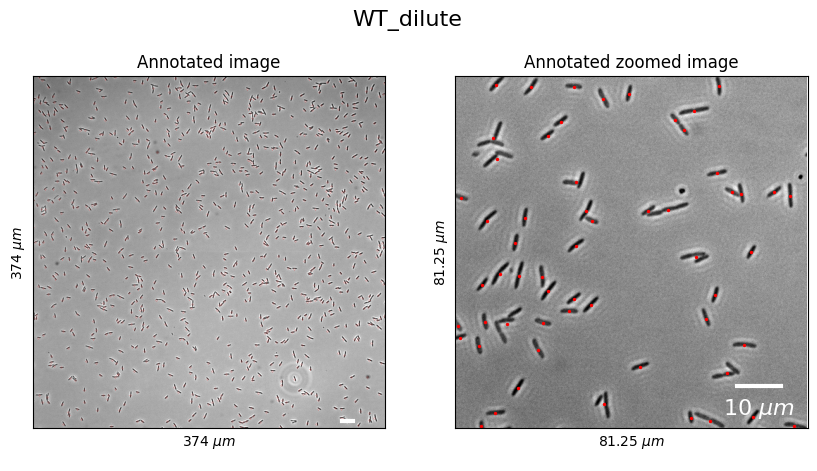

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# add a figure title
fig.suptitle('WT_dilute', fontsize=16)
ax[0].imshow(data['WT_dilute'][0], cmap='gray')
ax[0].scatter(centroids[:,0], centroids[:,1], color='red', s=0.01)
ax[0].set_title('Annotated image')
ax[0].set_xlabel('374 $\mu m$')
ax[0].set_ylabel('374 $\mu m$')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].plot([1800, 1862], [2000, 2000], color='white', linewidth=3) # 1 pixel = 0.1625 microns --> 10 microns = 61.25 pixels
ax[0].text(1650, 2200, '10 $\mu m$', color='white', fontsize=16)

ax[1].imshow(data['WT_dilute'][0,0:500,0:500], cmap='gray')
ax[1].scatter(centroids[:,0], centroids[:,1], color='red', s=2)
ax[1].set_title('Annotated zoomed image')
ax[1].set_xlabel('81.25 $\mu m$') # 1 pixel = 0.1625 microns --> 500 pixels = 81.25 microns
ax[1].set_ylabel('81.25 $\mu m$') # 1 pixel = 0.1625 microns --> 500 pixels = 81.25 microns
ax[1].set_xticks([])
ax[1].set_yticks([])
# set axes limits
ax[1].set_xlim(0, 500)
ax[1].set_ylim(0, 500)
ax[1].plot([400, 462], [60, 60], color='white', linewidth=3) # 1 pixel = 0.1625 microns --> 10 microns = 61.25 pixels
ax[1].text(380, 20, '10 $\mu m$', color='white', fontsize=16)

plt.show()

In [90]:
# get the centroids of the video into a dataframe with the frame number as index
print('Getting the centroids of {}...'.format('WT_dilute'))
list_ = []
for i in tqdm(range(data_seg['WT_dilute'].shape[0])):
    temp = getContours(data_seg['WT_dilute'][i,...].astype(np.uint8), 50, 200)
    for j in range(len(temp)):
        # add a row to the dataframe with the x and y coordinates and the frame number
        list_.append([temp[j,0], temp[j,1], temp[j,2], i])

centroids = pd.DataFrame(list_, columns=['x', 'y', 'nematic', 'frame'])

Getting the centroids of WT_dilute...


100%|██████████| 211/211 [00:11<00:00, 17.69it/s]


In [91]:
tracks = tp.link(centroids, 5, memory=3)

Frame 210: 892 trajectories present.


In [92]:
# filter the tracks to remove the ones that are too short (less than 20 frames)
filtered_tracks = tp.filter_stubs(tracks, 200)

# compare the number of particles before and after filtering
print('Before:', tracks['particle'].nunique())
print('After:', filtered_tracks['particle'].nunique())

Before: 25179
After: 102


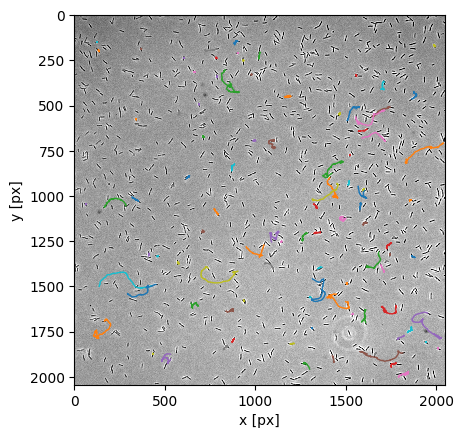

In [93]:
# plot the trajectories of the particles
tp.plot_traj(filtered_tracks, superimpose=data['WT_dilute'][0,...])
plt.show()

<Figure size 1000x1000 with 0 Axes>

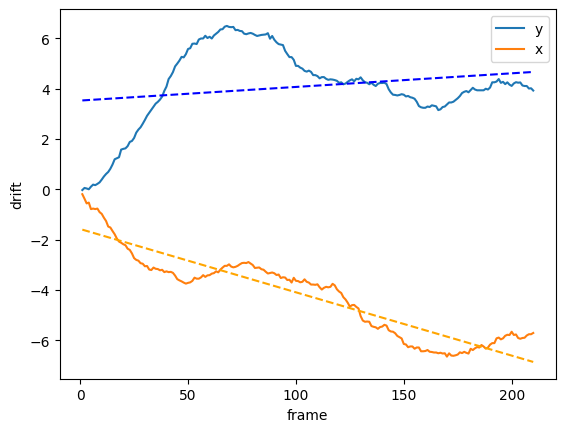

In [94]:
# compute the general drift in the movie
drift = tp.compute_drift(filtered_tracks)

# compute the linear fit
slopey, intercepty = np.polyfit(drift.index, drift['y'], 1)
slopex, interceptx = np.polyfit(drift.index, drift['x'], 1)

# plot the drift
plt.figure(figsize=(10, 10))
ax = drift.plot()
ax.set_xlabel('frame')
ax.set_ylabel('drift')
plt.plot(drift.index, drift.index*slopex + interceptx, '--', c='orange')
plt.plot(drift.index, drift.index*slopey + intercepty, '--', c='blue')
plt.show()

# correct the drift in the movie
filtered_tracks = tp.subtract_drift(filtered_tracks.copy(), drift)

In [95]:
# get the number of different particles
n_particles = filtered_tracks['particle'].nunique()
print('Number of particles:', n_particles)

Number of particles: 102


In [96]:
# sort the tracks by the standard deviation of the x and  y coordinates, to sort them by most moving particles
poi_number = 24
poi = filtered_tracks.groupby('particle').std().sort_values(by=['x', 'y'], ascending=False).head(poi_number).index

In [97]:
# select the tracks of interest from the filtered tracks
tracks_of_interest = filtered_tracks[filtered_tracks['particle'].isin(poi)]

In [98]:
# create a RGB movie of the tracks of interest
RGB_movie = np.zeros((data['WT_dilute'].shape[0], data['WT_dilute'].shape[1], data['WT_dilute'].shape[2], 3), dtype=np.uint8)
for frame_idx in tqdm(range(data['WT_dilute'].shape[0])):
    RGB_frame = cv2.cvtColor(data['WT_dilute'][frame_idx], cv2.COLOR_GRAY2RGB)
    for j in range(poi_number):
        df_temp = tracks_of_interest.groupby('particle').get_group(poi[j])
        try:
            for i in range(frame_idx):
                RGB_frame = cv2.circle(RGB_frame, (int(df_temp.iloc[i,0]), int(df_temp.iloc[i,1])), 2, colors[j], -1)
        except:
            pass

    RGB_movie[frame_idx,...] = RGB_frame


100%|██████████| 211/211 [00:58<00:00,  3.58it/s]


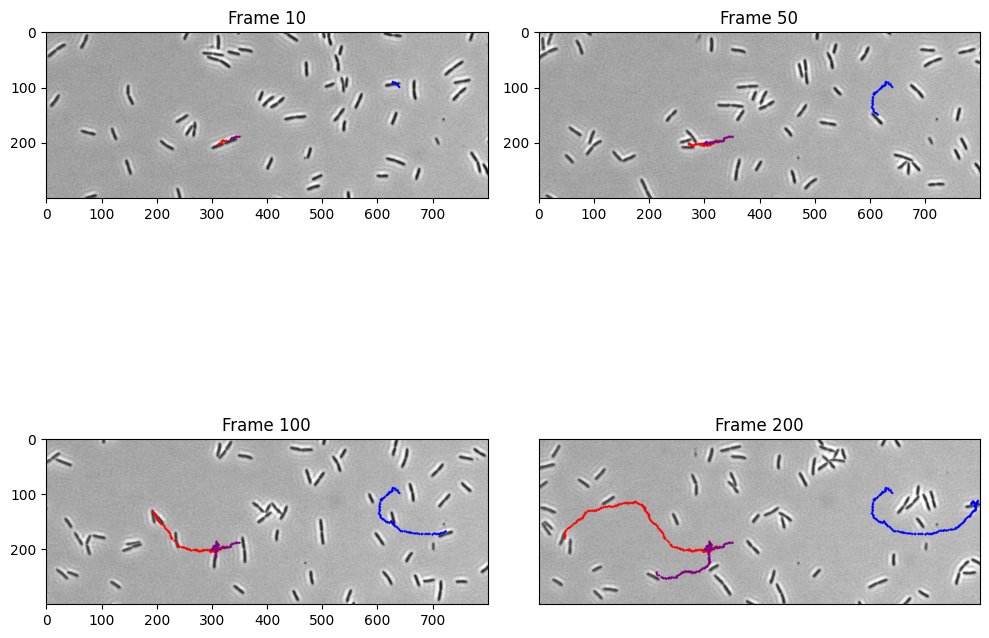

In [99]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), tight_layout=True)
frames = [10, 50, 100, 200]

# plot in a 2x2 image the 4 frames from the list 
for i in range(len(frames)):
    ax[i//2, i%2].imshow(RGB_movie[frames[i],1300:1600,100:900,:])
    ax[i//2, i%2].set_title('Frame {}'.format(frames[i]))

plt.xticks([])
plt.yticks([])
plt.show()

In [78]:
# resize the RGB movie
size = (1000,1000)
RGB_movie_resized = np.zeros((RGB_movie.shape[0], size[0], size[1], 3), dtype=np.uint8)
for i in tqdm(range(RGB_movie.shape[0])):
    RGB_movie_resized[i,...] = cv2.resize(RGB_movie[i,...], (size[0], size[1]))

100%|██████████| 211/211 [00:00<00:00, 331.61it/s]


In [79]:
play_video(RGB_movie_resized)

In [100]:
# function to track the particles
def track_bacteria(input_video_name, max_pix_dist=5, memory=3, min_frames=200, min_area=50, max_area=200, corr_drift=True, number_of_bacteria_of_interest=24, save_movie=False, saved_video_name='DEFAULT'):
    # get the centroids of the video into a dataframe with the frame number as index
    print('Getting the centroids...')
    list_ = []
    video = data_seg[input_video_name]
    for i in tqdm(range(video.shape[0])):
        temp = getContours(video[i,...].astype(np.uint8), min_area, max_area)
        for j in range(len(temp)):
            # add a row to the dataframe with the x and y coordinates and the frame number
            list_.append([temp[j,0], temp[j,1], temp[j,2], i])

    centroids = pd.DataFrame(list_, columns=['x', 'y', 'nematic_order', 'frame'])

    # track the centroids through the frames of the video
    print('Tracking the centroids...')
    tracks = tp.link(centroids, max_pix_dist, memory=memory)
    
    # filter the tracks to remove the ones that are too short (less than 200 frames)
    print('Filtering the tracks by length...')
    print('Before:', tracks['particle'].nunique())
    tracks = tp.filter_stubs(tracks, min_frames)
    print('After:', tracks['particle'].nunique())

    if corr_drift:
        # compute the general drift in the movie
        print('Correcting the drift...')
        drift = tp.compute_drift(tracks)
        # correct the drift in the movie
        tracks = tp.subtract_drift(tracks.copy(), drift)

    # get the number of frames for the particles
    n_particles = tracks['particle'].nunique()
    lengths = np.zeros(n_particles)
    for i in range(n_particles):
        try:
            lengths[i] = tracks.groupby('particle').get_group(i).shape[0]
        except:
            pass
    
    # sort the tracks by the standard deviation of the x and  y coordinates, to sort them by most moving particles
    poi = tracks.groupby('particle').std().sort_values(by=['x', 'y'], ascending=False).head(number_of_bacteria_of_interest).index
    
    # select the tracks of interest from the filtered tracks
    tracks = tracks[tracks['particle'].isin(poi)]
    
    # create a RGB movie of the tracks of interest
    print('Creating the tracking RGB movie...')
    RGB_movie = np.zeros((video.shape[0], video.shape[1], video.shape[2], 3), dtype=np.uint8)
    for frame_idx in tqdm(range(video.shape[0])):
        RGB_frame = cv2.cvtColor(data[input_video_name][frame_idx], cv2.COLOR_GRAY2RGB)
        for j in range(number_of_bacteria_of_interest):
            df_temp = tracks.groupby('particle').get_group(poi[j])
            
            try:
                for i in range(frame_idx):
                    RGB_frame = cv2.circle(RGB_frame, (int(df_temp.iloc[i,0]), int(df_temp.iloc[i,1])), 2, colors[j%len(colors)], -1)
            except:
                pass

        RGB_movie[frame_idx,...] = RGB_frame
    
    if save_movie:
        # save the RGB movie
        print('Saving the tracking RGB movie...')
        tiff.imwrite('../data_project1/{}.tif'.format(saved_video_name), RGB_movie_resized)

    nematic_order_ = centroids['nematic_order'].mean()
    print('Nematic order parameter:', nematic_order_)

    return tracks, RGB_movie, centroids['nematic_order']

In [106]:
tracks_pilH_dilute, RGB_movie_, nematic_orders_pilH_dilute = track_bacteria('pilH_dilute', max_pix_dist=5, memory=3, min_frames=200, min_area=20, max_area=200, corr_drift=True, number_of_bacteria_of_interest=24, save_movie=True, saved_video_name='pilH_dilute_tracked')

Frame 240: 565 trajectories present.
Filtering the tracks by length...
Before: 3210
After: 204
Correcting the drift...
Creating the tracking RGB movie...


100%|██████████| 241/241 [01:06<00:00,  3.61it/s]


Saving the tracking RGB movie...
Nematic order parameter: 0.24698068275596802


In [107]:
tracks_pilG_dilute, RGB_movie_, nematic_orders_pilG_dilute = track_bacteria('pilG_dilute', max_pix_dist=5, memory=3, min_frames=200, min_area=20, max_area=200, corr_drift=True, number_of_bacteria_of_interest=24, save_movie=True, saved_video_name='pilG_dilute_tracked')

Frame 240: 1196 trajectories present.
Filtering the tracks by length...
Before: 9647
After: 468
Correcting the drift...
Creating the tracking RGB movie...


100%|██████████| 241/241 [01:06<00:00,  3.64it/s]


Saving the tracking RGB movie...
Nematic order parameter: 0.2203001845327909


In [108]:
tracks_WT_dilute, RGB_movie_, nematic_orders_WT_dilute = track_bacteria('WT_dilute', max_pix_dist=5, memory=3, min_frames=200, min_area=20, max_area=200, corr_drift=True, number_of_bacteria_of_interest=24, save_movie=True, saved_video_name='WT_dilute_tracked')

Frame 210: 1143 trajectories present.
Filtering the tracks by length...
Before: 28160
After: 144
Correcting the drift...
Creating the tracking RGB movie...


100%|██████████| 211/211 [00:55<00:00,  3.82it/s]


Saving the tracking RGB movie...
Nematic order parameter: 0.26546246673120943


In [85]:
# play the video (press q to quit at any time)
play_video(np.array(pims.TiffStack('../data_project1/pilH_dilute_tracked.tif')))


### Try using trackpy

In [402]:
# apply the tracking to the whole video
tracks = tp.batch(data_seg['WT_dilute'], 23, invert=False, threshold=0, minmass=40)

Frame 210: 884 features


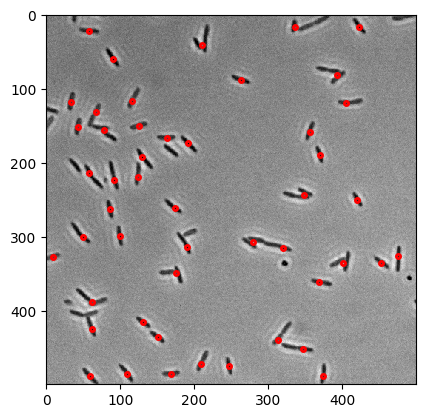

<Axes: >

In [274]:
# plot the first frame of the video with the tracks
tp.annotate(tracks[tracks['frame']==0], data['WT_dilute'][0][0:500,0:500], plot_style={'markersize': 3, 'alpha': 1})

In [ ]:
tracks = tp.link_df(tracks, 5, memory=3)

## Analysis

In [110]:
# compute the ensemble mean squared displacement
# for this you might encounter an error of this type: TypeError: mean() got an unexpected keyword argument 'level'
# to solve this error, you need to modify the file trackpy/motion.py at the following lines:
# Line 235: results = msds.mul(msds['N'], axis=0).groupby(level=1).mean()  # weighted average
# Line 236: results = results.div(msds['N'].groupby(level=1).mean(), axis=0)  # weights normalized
# then close and reopen VS Code


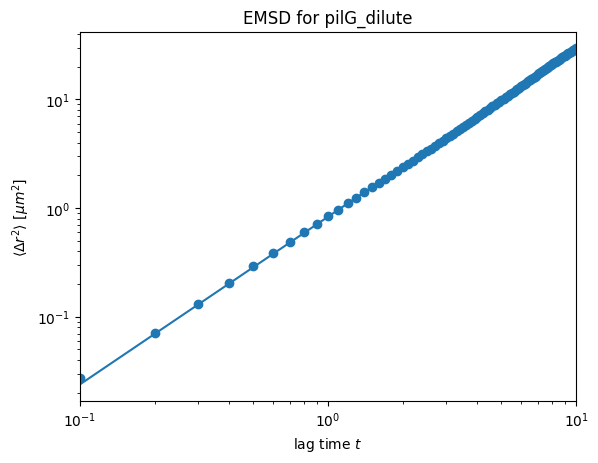

,n,A
msd,1.54246,0.833352


In [113]:
emsd = tp.emsd(tracks_pilG_dilute, 0.1625, 10) # 1 pixel = 0.1625 microns, 10 frames per second
# fit a linear curve to log-log plot of the ensemble mean squared displacement
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu m^2$]')
plt.xlabel('lag time $t$')
plt.title('EMSD for pilG_dilute')
tp.utils.fit_powerlaw(emsd)

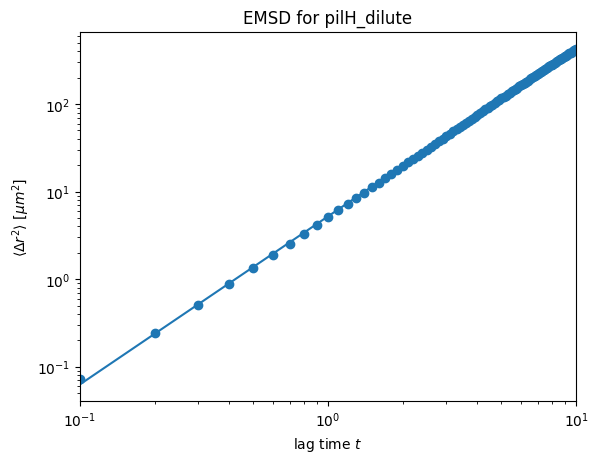

,n,A
msd,1.919838,5.225071


In [114]:
emsd = tp.emsd(tracks_pilH_dilute, 0.1625, 10) # 1 pixel = 0.1625 microns, 10 frames per second
# fit a linear curve to log-log plot of the ensemble mean squared displacement
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu m^2$]')
plt.xlabel('lag time $t$')
plt.title('EMSD for pilH_dilute')
tp.utils.fit_powerlaw(emsd)

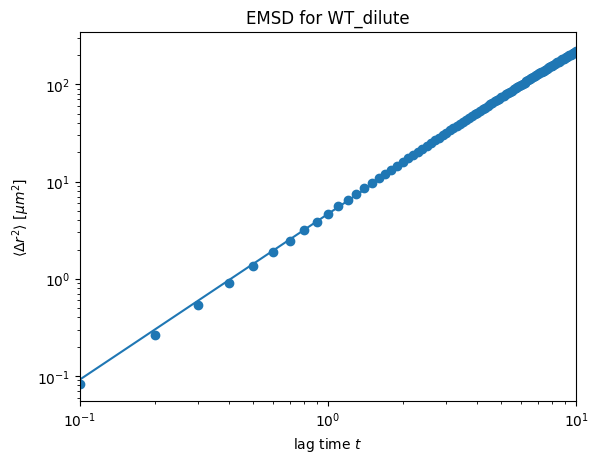

,n,A
msd,1.703179,4.654144


In [115]:
emsd = tp.emsd(tracks_WT_dilute, 0.1625, 10) # 1 pixel = 0.1625 microns, 10 frames per second
# fit a linear curve to log-log plot of the ensemble mean squared displacement
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu m^2$]')
plt.xlabel('lag time $t$')
plt.title('EMSD for WT_dilute')
tp.utils.fit_powerlaw(emsd)

### Nematic order

201it [04:32,  1.35s/it]


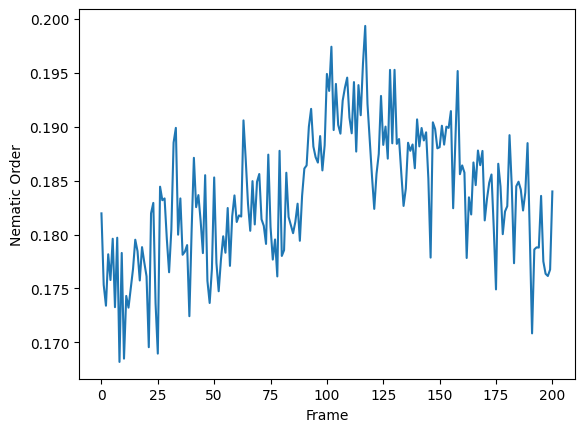

In [289]:
l = []
S = []
for i, frame in tqdm(enumerate(v_WT_dense)):
    frame = masker(frame)
    contours, hierarchy = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    s = []
    for c in contours:
        if len(c) < 5:
            continue
        M = cv2.moments(c)
        try:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        except:
            continue
        
        ell = cv2.fitEllipse(c)
        ellipse_axes = ell[1]
        s.append(3 / 2 * np.cos(np.deg2rad(ell[2])) ** 2 - 1/2) # ell[2] returns the angle of the ellipse to the vertical in degrees
        ma = min(ellipse_axes)
        MA = max(ellipse_axes)
        ecc = np.sqrt(1 - (ma / MA) ** 2)   
        l.append([cY, cX, ecc, i])

    S.append(np.mean(s))

plt.plot(S)
plt.ylabel('Nematic Order')
plt.xlabel('Frame')
plt.show()


features = pd.DataFrame(l, columns=['y', 'x', 'ecc', 'frame'])

In [290]:
features

,y,x,ecc,frame
0,2302,1736,1.000000,0
1,2302,573,1.000000,0
2,2302,56,1.000000,0
3,2302,2210,0.946713,0
4,2302,1582,0.788993,0
...,...,...,...,...
4461438,1,428,0.707107,200
4461439,10,324,0.660999,200
4461440,10,324,0.739399,200
4461441,6,310,0.856895,200
